In [3]:
import sys

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as tfhub

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
W0425 14:33:07.024722 140217569580800 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [4]:
!test -d bert_repo || git clone https://github.com/google-research/bert bert_repo
if not 'bert_repo' in sys.path:
  sys.path += ['bert_repo']

# import python modules defined by BERT
import modeling
import optimization
import run_classifier
import run_classifier_with_tfhub
import tokenization

In [4]:
!test -d ../input || mkdir ../input
!test -f ../input/test_stage_1.tsv || wget http://leatherngear.com/kaggle/test_stage_1.tsv -O ../input/test_stage_1.tsv -o /dev/null
!test -f ../input/right_answers.csv || wget http://leatherngear.com/kaggle/right_answers.csv -O ../input/right_answers.csv -o /dev/null
!ls ../input

right_answers.csv  sample_submission_stage_1.csv  test_stage_1.tsv


In [16]:
def get_train_data():
    return pd.read_csv("../input/test_stage_1.tsv", sep="\t", index_col=0)

train_data = get_train_data()
train_data.head(2)

,Text,Pronoun,Pronoun-offset,A,A-offset,B,B-offset,URL
ID,,,,,,,,
development-1,Zoe Telford -- played the police officer girlf...,her,274,Cheryl Cassidy,191,Pauline,207,http://en.wikipedia.org/wiki/List_of_Teachers_...
development-2,"He grew up in Evanston, Illinois the second ol...",His,284,MacKenzie,228,Bernard Leach,251,http://en.wikipedia.org/wiki/Warren_MacKenzie


In [9]:
!head -n 3 ../input/right_answers.csv

ID,A,B,NEITHER
development-1,1,0,0
development-2,1,0,0


In [20]:
def get_train_labels():
    return pd.read_csv('../input/right_answers.csv', index_col=0).values

In [82]:
def score(labels):
    """ 
    Arguments:
        labels: one-hot encoded nx3 array of labels [A, B, NEITHER]
    """
    a_bit = 10e-15
    right_answers = get_train_labels()
    l = np.maximum(np.minimum(labels, 1-a_bit), a_bit)
    # normalize rows to sum up to 1
    l = l / np.tile(l.sum(axis=1), (3, 1)).T
    return -(right_answers * np.log(l)).sum() / len(l)

random_answers = pd.read_csv('../input/sample_submission_stage_1.csv', index_col=0).values
score(random_answers)

1.0986122886681096

In [50]:
def accuracy(labels):
    right_answers = get_train_labels()
    n = len(labels)
    one_hot = np.zeros(right_answers.shape)
    one_hot[np.arange(n), np.argmax(labels)] = 1
    return (one_hot * right_answers).sum() / n

always_left = np.zeros((len(train_data), 3), dtype=int)
always_left[:, 0] = 1  
print(accuracy(always_left))  # A: 43.7,   B: 46.25,  Neither: 10.05
print(score(always_left))

0.437
18.148975702979072


# Naive approaches

In [83]:
# dumbest approach ever - balance by probability
balanced = np.zeros((len(train_data), 3))
balanced[:, 0] = 0.437
balanced[:, 1] = 0.4625
balanced[:, 2] = 0.1005
# accuracy is still 46.25
print(score(balanced))

0.9493045885211795


In [39]:
# predict the one that is fewer characters away from the pronoun
# B is practically always closer, so result is equivalent to "always B"
closest_char = np.zeros((len(train_data), 3), dtype=int)
closest_char[np.arange(len(closest_char)), 
        ((train_data['Pronoun-offset'] - train_data['A-offset']).abs() > 
        (train_data['Pronoun-offset'] - train_data['B-offset']).abs()).astype(int)
       ] = 1
accuracy(closest_char)

0.4625

In [43]:
# predict the one closest in words - same effect
train_data['A-word'] = train_data.apply(lambda row: len(row['Text'][:row['A-offset']].split()), axis=1)
train_data['B-word'] = train_data.apply(lambda row: len(row['Text'][:row['B-offset']].split()), axis=1)
train_data['Pronoun-word'] = train_data.apply(lambda row: len(row['Text'][:row['Pronoun-offset']].split()), axis=1)
# train_data[['A-word', 'B-word', 'Pronoun-word']]
# train_data[['A-offset', 'B-offset', 'Pronoun-offset']]

closest_word = np.zeros((len(train_data), 3), dtype=int)
closest_word[np.arange(len(closest_word)), 
        ((train_data['Pronoun-word'] - train_data['A-word']).abs() > 
        (train_data['Pronoun-word'] - train_data['B-word']).abs()).astype(int)
       ] = 1
accuracy(closest_word)

0.4625

In [102]:
# use distance as probability - same as balance by probability
predictions = train_data[['A-offset', 'B-offset', 'Pronoun-offset']].values - train_data[['Pronoun-offset', 'Pronoun-offset', 'Pronoun-offset']].values
predictions[:, 2] = 500
predictions = 620 - np.abs(predictions)
# predictions /= np.tile(predictions.sum(axis=1), (3, 1)).T
# score(predictions)
score(predictions / np.tile(predictions.sum(axis=1), (3, 1)).T)

0.9498397478205609

# Bert

In [111]:
# other models:
# uncased_L-24_H-1024_A-16
# cased_L-12_H-768_A-12
BERT_MODEL = 'uncased_L-12_H-768_A-12' #@param {type:"string"}
BERT_MODEL_HUB = 'https://tfhub.dev/google/bert_' + BERT_MODEL + '/1'
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip


--2019-04-26 12:26:17--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.10.48, 2607:f8b0:4006:813::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.10.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  42.0MB/s    in 8.6s    

2019-04-26 12:26:26 (45.2 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [113]:
# tokenizer = run_classifier_with_tfhub.create_tokenizer_from_hub_module(BERT_MODEL_HUB)

In [108]:
example = train_data.loc['development-1', 'Text']
print(example)

Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.


In [109]:
tokenizer.tokenize(example)

['zoe',
 'tel',
 '##ford',
 '-',
 '-',
 'played',
 'the',
 'police',
 'officer',
 'girlfriend',
 'of',
 'simon',
 ',',
 'maggie',
 '.',
 'dumped',
 'by',
 'simon',
 'in',
 'the',
 'final',
 'episode',
 'of',
 'series',
 '1',
 ',',
 'after',
 'he',
 'slept',
 'with',
 'jenny',
 ',',
 'and',
 'is',
 'not',
 'seen',
 'again',
 '.',
 'phoebe',
 'thomas',
 'played',
 'cheryl',
 'cassidy',
 ',',
 'pauline',
 "'",
 's',
 'friend',
 'and',
 'also',
 'a',
 'year',
 '11',
 'pupil',
 'in',
 'simon',
 "'",
 's',
 'class',
 '.',
 'dumped',
 'her',
 'boyfriend',
 'following',
 'simon',
 "'",
 's',
 'advice',
 'after',
 'he',
 'wouldn',
 "'",
 't',
 'have',
 'sex',
 'with',
 'her',
 'but',
 'later',
 'realised',
 'this',
 'was',
 'due',
 'to',
 'him',
 'catching',
 'crabs',
 'off',
 'her',
 'friend',
 'pauline',
 '.']

In [7]:
corpus = pd.read_csv("../input/test_stage_1.tsv", sep='\t', index_col='ID')
corpus.head(2)

,Text,Pronoun,Pronoun-offset,A,A-offset,B,B-offset,URL
ID,,,,,,,,
development-1,Zoe Telford -- played the police officer girlf...,her,274,Cheryl Cassidy,191,Pauline,207,http://en.wikipedia.org/wiki/List_of_Teachers_...
development-2,"He grew up in Evanston, Illinois the second ol...",His,284,MacKenzie,228,Bernard Leach,251,http://en.wikipedia.org/wiki/Warren_MacKenzie


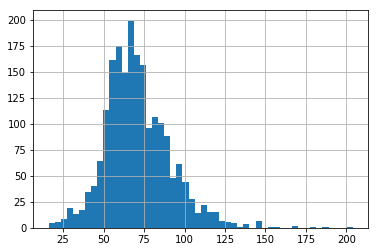

In [8]:
corpus['text_len'] = corpus['Text'].map(lambda s: len(s.split()))
corpus['text_len'].hist(bins=50)

In [9]:
corpus['a_left'] = (corpus['Pronoun-offset'] > corpus['A-offset']).astype(int)
corpus['b_left'] = (corpus['Pronoun-offset'] > corpus['B-offset']).astype(int)
corpus[['Pronoun-offset', 'a_left', 'b_left']].groupby(['a_left', 'b_left']).count()

Pronoun-offset
a_left b_left                
0      0                  274
1      0                  222
       1                 1504